<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Aims-and-objectives" data-toc-modified-id="Aims-and-objectives-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Aims and objectives</a></span></li><li><span><a href="#EBC-model-backbone---NPZD-model" data-toc-modified-id="EBC-model-backbone---NPZD-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EBC model backbone - NPZD model</a></span></li><li><span><a href="#overarching-equation-bin" data-toc-modified-id="overarching-equation-bin-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>overarching equation bin</a></span></li><li><span><a href="#NPZD-Model-from-literature" data-toc-modified-id="NPZD-Model-from-literature-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>NPZD Model from literature</a></span></li><li><span><a href="#carbon-sequestration-revenue-(photosynthesis)-rate" data-toc-modified-id="carbon-sequestration-revenue-(photosynthesis)-rate-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>carbon sequestration revenue (photosynthesis) rate</a></span></li><li><span><a href="#electricigen-detritivore-population-electricity-relationship" data-toc-modified-id="electricigen-detritivore-population-electricity-relationship-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>electricigen detritivore population-electricity relationship</a></span></li><li><span><a href="#eco-bioelectric-cell-(EBC)" data-toc-modified-id="eco-bioelectric-cell-(EBC)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>eco-bioelectric cell (EBC)</a></span></li></ul></div>

In [1]:
using RCall, PyCall, Plots, ProgressMeter, DataFrames
mt = pyimport("math")
sc = pyimport("scipy")
cst = pyimport("scipy.constants")
itg = pyimport("scipy.integrate")
R"cbp<-c('#000000', '#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#e79f00', '#9ad0f3', '#F0E442', '#999999', '#cccccc', '#6633ff', '#00FFCC', '#0066cc')"
println()

# Aims and objectives
1. model replication on EMPOWER model ([Anderson et al, 2015](https://eprints.soton.ac.uk/382241/1/gmd-8-2231-2015.pdf))
2. combine and list out equations useful for the model of eco-bioelectric cell
3. establish relationship between electricigen microbe population and power output

# EBC model backbone - NPZD model

![](graph/model_01_r.png)

NPZD model is a phenomenological ordinary differential equation (ODE) model in ocean science focus on describing the population dynamics of four major biochemical engines powering the oceanic carbon cycle system.  The nutrient pool (denoted by [$N$]) is consisting of inorganic nutrient essential for phytoplankton population growth.  Phytoplankton population (denoted by [$P$]) is assumed only one type of phytoplankton, grow by absorbing $N$ and is the food source of zooplankton (denoted by [$Z$]).  $Z$ is assumed only one type of zooplankton, food sources are including $P$ and detritus/organic matter (denoted by [$D$]) for its population growth.  $Z$ can only absorb nutrient through digestion of detritus into inorganic nutrient.  Due to the non-perfect absorption system, some "digested but not absorbed" inorganic chemical species can escape from zooplankton bodies and contribute to the $N$ pool.  For the $D$ pool, it is a collection of organic matter, including and mostly consist of cellular leftovers (i.e. dead cells from $P$ and $Z$).  It is a food source for $Z$, completing the microscopic oceanic carbon cycle.

![](graph/model_Jupyter01.png)

Inspired by the EMPOWER model ([Anderson et al, 2015](https://eprints.soton.ac.uk/382241/1/gmd-8-2231-2015.pdf)), I proposed a variation from the NPZD model, replacing the generalist $Z$ to a specialist bacteria _E. coli_ (denoted by $B$) which only feed on detritus.  In that case, $P$ and $B$ is not prey-predator relationship but indirect mutualists for nutrients ($P$ contribute to food source of $B$ and vice versa).  The aim for this model is to look at whether the population of $B$ and $D$ can grow so that $B$ population can produce household-scaled electrical power output and $D$ can be collected as a source of fixed carbon.  This ecosystem would be the anode part of the whole EBC, which the cathode part would be a Lactobacillus fermentation chamber.  This homofermentation chamber can also fossilize the fixed carbon from organic matter into irrespirable lactates, making it bio-unavailable to contribute as a greenhouse gas species naturally.  Yet as the chamber is not interacting with the oxic anode ecosystem, it is ignored in the EBC model.

# overarching equation bin
Grazing
\begin{equation}
    G_X = ZI_{Zmx}\Big[ \dfrac{(X/k_X)^2}{1+(P/k_P)^2+(D/k_D)^2} \Big]\text{, which X = P or D} 
\end{equation}

This grazing pressure ($G_X$) equation is extracted from [Anderson et al, 2015](https://eprints.soton.ac.uk/382241/1/gmd-8-2231-2015.pdf).  The term describes the predation pressure of zooplankton (Z) on phytoplankton (P) or detritus (D).  In the equation, $Z$ is the popoulation size of zooplankton, $P$ is that for phytoplankton and $D$ is for detritus.  $k_P$ is the half-saturation constant of P and $k_D$ is that for detritus.  $I_{Zmax}$ is the maximum ingestion rate of zooplankton.  The term orientation shows a positive relationship between grazing pressure linearly with predator $Z$ population size and their maximum ingestion rate.  This terms is also quadratically positive correlating with a fraction of food population and their half-saturation level.  This equation was having a slight algebraic rearrangement from [Anderson et al, 2015](https://eprints.soton.ac.uk/382241/1/gmd-8-2231-2015.pdf), in which the term $k_Z$ was eliminated.  This shows grazing pressure is not hindered by the predator half-saturation level.  The grazing pressure was also inversely proportional to the sum of food descriptions plus one.

In [2]:
function grazing(pops, kSer, X, igt) ## tested
    ## igt = maximum ingestion rate of zooplankton
    
    P = pops[:2] # phytoplankton population size
    Z = pops[:3] # zooplankton population size
    D = pops[:4] # detritus population size
    
    kP = kSer[:2] # phytoplankton half-saturation constant
    kD = kSer[:3] # detritus half-saturation constant
    
    if X==1
        X = kP
        kX = kP
    else
        X = kD
        kX = kD
    end
    
    gz = Z*igt*(X/kX)^2/(1+(P/kP)^2+(D/kD)^2)
    return(gz)
end

grazing (generic function with 1 method)

Chlorophyll concentration (from [Randolph et al, 2008](https://www.sciencedirect.com/science/article/pii/S0034425708002022))
\begin{equation}
    \text{cellConc }(\dfrac{mm^3}{m^3}) = 125.2+4.01\times[\text{chlConc}(ppb)]
\end{equation}
\begin{align}
    \text{cellConc }(\dfrac{mm^3}{m^3}) &= \dfrac{4\pi r^3/3 (mm^3)\cdot\text{population}}{x\cdot y\cdot z (m^3)}\text{, which r is cellular radius in unit $mm$ assuming spherical cell}\nonumber\\
    &= \dfrac{4\pi r^3 (mm^3)\cdot\text{population}}{3z (m^3)}\text{, assume x=y=1 for standard SI unit calculation}
\end{align}
\begin{equation}
    ppb = \mu g/L = \dfrac{1}{1000}\dfrac{mg}{dm^3} = \dfrac{1000}{1000}\dfrac{mg}{m^3} = \dfrac{mg}{m^3}
\end{equation}
\begin{align}
    \dfrac{4\pi r^3}{3z} &= 125.2+4.01\times[\text{chlConc}(ppb)]\nonumber\\
    [\text{chlConc}(mg/m^3)] &= (\dfrac{4\pi r^3[pop]-125.2(3z)}{3z\cdot4.01})
\end{align}

In [3]:
function chlConc(pop, r, z) ## tested
    conc = (4*mt.pi*r^3*pop - 125.2*3*z)/(3*z*4.01)
    if conc <0
        conc = 0
    end
    return (conc)
end

chlConc (generic function with 1 method)

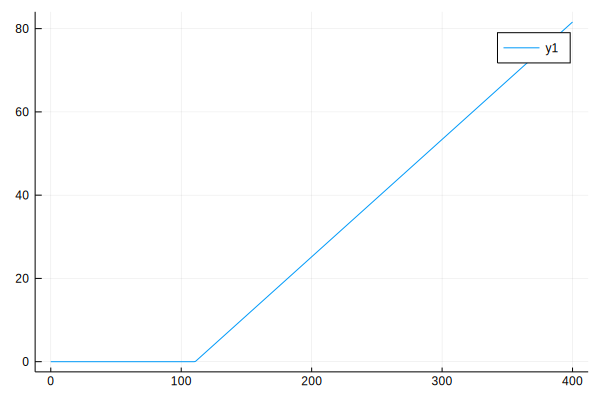

In [4]:
## testing population effect on chlorophyll conc
a = [x for x in 0:1:convert(Int, 4e2)]
a = DataFrame(i=a,c=[chlConc(a[i],.3,.1) for i in 1:length(a)])
plot(a[:,1],a[:,2])

Light intensity
\begin{align}
    i_{t,z} &= i(t)e^{-k_{PAR}z}\\
    k_{PAR} &= b_{0,i} + b_{1,i}C^{0.5} + b_{2,i}C + \cdots + b_{5,i}C^{2.5}\\
    k_{PAR} &= k_w + k_cP
\end{align}

The light intensity function ($i_{t,z}$) was an exponential function extracted from [Anderson et al, 2015](https://eprints.soton.ac.uk/382241/1/gmd-8-2231-2015.pdf) relating to the incident irradiation at water surface ($i(t)$, i.e. at sea-level from the original environmental setting).  The incident irradiation is time-dependent ($t$), modified by the exponential term.  The exponential term is a difference equation ($k_{PAR}$) describing chlorophyll concentration ($C$, mg/m$^3$) and some experimental constants (i.e. $b_{0,i}$, $b_{1,i}$ ... $b_{5,i}$) from the site of interest.  This part is negatively correlated with depth, meaning lower light intensity (decreasing in exponential behaviour) would result from increasing depth ($z$).  It is also to pull phytoplankton population size with chlorophyll density through linear relationship estimation from [Randolph et al, 2008](https://www.sciencedirect.com/science/article/pii/S0034425708002022)

$k_{PAR}$ can also take another equation which directly take into account of the popoulation of phytoplankton and is adopted in this project.  In the equation, two constants $k_w$ (attenuation of water, 0.04$m^2/mmolN$) and $k_c$ (attenuation of chlorophyll, 0.03$m^2/mmolN$) were often adopted in papers and also used in [Anderson et al, 2015](https://eprints.soton.ac.uk/382241/1/gmd-8-2231-2015.pdf).

In [5]:
function intensity(pop, iT, r, z) ## tested
    ## bSer = coefficient series (6 elements) from paper for differential equation
    bSer=sc.array([0.13096, 0.030969, 0.042644, -.013738, 0.0024617, -.00018059]) # top 5m polynomial coefficients
    C = chlConc(pop, r, z) ## chlorophyll conc (mg/m^3)
    kPAR = bSer[:1] + bSer[:2]*C^.5 + bSer[:3]*C + bSer[:4]*C^1.5 + bSer[:5]*C^2 + bSer[:6]*C^2.5
    
    ## iT = incident irradiation at water surface
    ## kPAR = sum of attenuation due to water and phytoplankton
    iTz = iT*mt.exp(-kPAR*z)
    return(iTz)
end

intensity (generic function with 1 method)

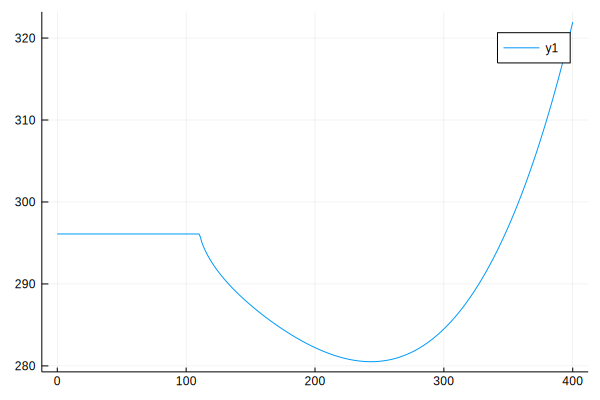

In [6]:
## testing population effect on intensity
a = [x for x in 0:1:convert(Int, 4e2)]
a = DataFrame(i=a,c=[intensity(a[i], 300,.3,.1) for i in 1:length(a)])
plot(a[:,1],a[:,2])

In [7]:
function inten(P, iT, z) ## tested
    ## iT = incident irradiation at water surface
    ## P = population of phytoplankton
    iTz = iT*mt.exp(-(0.04+0.03*P)*z)
    return(iTz)
end

inten (generic function with 1 method)

In [8]:
## testing population effect on intensity 2
a = [x for x in 0:1:convert(Int, 4e2)]
a = DataFrame(i=a,c=[inten(a[i], 300,.1) for i in 1:length(a)])
plot(a[,1],a[,2])

LoadError: syntax: unexpected ","

phytoplankton growth rate
\begin{equation}
    \mu_P = \mu_P^{max}(0)\cdot1.066^T\cdot\dfrac{N}{k_N+N}\cdot\dfrac{I(t)}{k_{I,t}+I(t)}
\end{equation}

Growth rate of phytoplankton ($\mu_P$) equation was adopted from [Anderson et al, 2015](https://eprints.soton.ac.uk/382241/1/gmd-8-2231-2015.pdf).  It is experimentally found to be correlated to the maximum growth rate when environment temperature is 0$^oC$ and a constant to the power of environmental temperature $T$.  Growth is proved to be limited by nutrient and light availability.  Hence the growth rate is further modified by positively-correlating with nutrient population ($N$) and inversely-correlated with the half-saturation level of the nutrient ($k_N$) plus nutrient population size.  The product is further modified with the same parameter definitions but using the light intensity function to link phytoplankton bioavailable energy with light availability.  The $k_{I,t}$, however, is the maximum light intensity within the smallest scale of the model (default: day).

In [9]:
function gRateP(pops, kSer, mu0, T, IntMax, iT, r, z) ## tested
    ## mu0 = max growth rate when temperature = 0 deg Celcius
    ## T = temperature (deg Celcius)
    ## IntMx = maximum light intensity
    N = pops[:1] # nutrient population size
    P = pops[:2] # phytoplankton population size
    kN = kSer[:1] # half-saturation constant: N-uptake
    
    muP = mu0*1.066^T*N/(kN+N)*intensity(P, iT, r, z)/(.5*IntMax+intensity(P, iT, r, z))
    return(muP)
end

gRateP (generic function with 1 method)

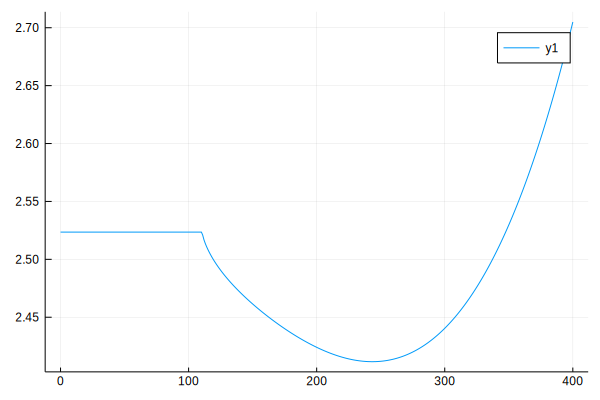

In [10]:
## testing population effect on chlorophyll conc
a = [x for x in 0:1:convert(Int, 4e2)]
a = DataFrame(i=a,c=[gRateP(sc.array([3,a[i]]),sc.array([1,1]),3,30,30,3,.3,.1) for i in 1:length(a)])
plot(a[:,1],a[:,2])

In [11]:
function gRP(pops, kSer, mu0, T, IntMax, iT, z) ## tested
    ## mu0 = max growth rate when temperature = 0 deg Celcius
    ## T = temperature (deg Celcius)
    ## IntMx = maximum light intensity
    N = pops[:1] # nutrient population size
    P = pops[:2] # phytoplankton population size
    kN = kSer[:1] # half-saturation constant: N-uptake
    
    muP = mu0*1.066^T*N/(kN+N)*inten(P, iT, z)/(.5*IntMax+inten(P, iT, z))
    return(muP)
end

gRP (generic function with 1 method)

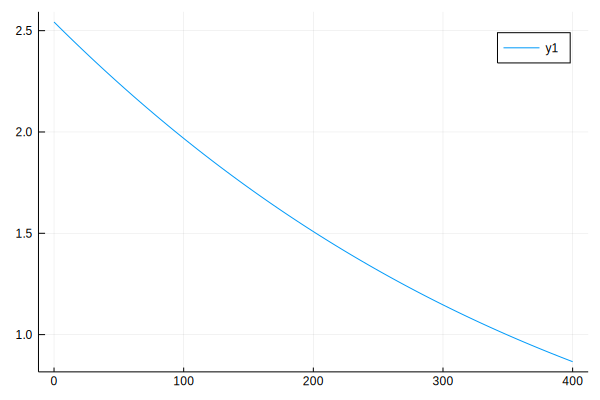

In [12]:
## testing population effect on chlorophyll conc
a = [x for x in 0:1:convert(Int, 4e2)]
a = DataFrame(i=a,c=[gRP(sc.array([3,a[i]]),sc.array([1,1]),3,30,30,3,.1) for i in 1:length(a)])
plot(a[:,1],a[:,2])

# NPZD Model from literature
\begin{equation}
\left\{\begin{array}{rl}
    N'(t) &= -\mu_PP + \beta_Z(1-k_{NZ})(G_P+G_D) + m_DD + (a_NZ + b_N - N)\cdot\dfrac{\omega_{mix}H'(t)}{H(t)}\\
    P'(t) &= \mu_PP - G_P - m_PP - m_{P2}P^2 - P\cdot\dfrac{\omega_{mix}H'(t)}{H(t)}\\
    Z'(t) &= \beta_Zk_N(G_P+G_D) - m_ZZ - m_{Z2}Z^2-Z\cdot\dfrac{\omega_{mix}H'(t)}{H(t)}\\
    D'(t) &= m_PP + m_{P2}P^2 + m_ZZ + (1-\beta_Z)(G_P+G_D) - G_D - (m_D + \dfrac{v_D}{H(t)})D -D\cdot\dfrac{\omega_{mix}H'(t)}{H(t)}
    \end{array}\right.
\end{equation}

The model is primarily describing a surface oceanic water column expanding from water surface to thermocline (i.e. a unit area with varying depth on mixed layer).  In this model, there were four ODEs describing four pools of components, one ODE for one pool: inorganic nutrition [N], phytoplanktons [P], herbivory zooplankton [Z] and organic matter / detritus [D].  In this model it is assumed there is only one type of player in each equation, hence eliminated interspecies competition, complex trophic relationships and food web considerations.  

Among these four equations there is a special cross-equation water column description term ($\dfrac{\omega_{mix}H'(t)}{H(t)}$):
*  positively relating to the rate of water mixing ($\omega_{mix}$) and rate of thermocline movement ($H'(t)$) with inverse relationship with depth of thermocline from water surface ($H(t)$)
* This is a general modification term in all four equations because the model assumes uniform distributions of all four players [N, P, Z, D].  Hence when rate of change is negative ($H'(t)<0$), the living space for all component would increase, leading to an immediate colonization of new available space (living components of surface water layer can't live beyond the depth of thermocline)
* however when depth of thermocline decrease ($H'(t)>0$), this makes the surface mixed layer thinner and hence living space of all components decreased.  Under the "constant concentration" assumption, this means players lived at the bottom part of the water column would be killed (and removed) from the system (this system is only modeling the surface layer, i.e. above thermocline)

The nutrient time series ODE [N'(t)]:
* $\mu_P$ is the growth term for phytoplankton [$P$], which draws nutrient out of the nutrient pool (-ve) according to the phytoplankton instantaneous population assuming nutrient:phytoplankton = 1:1
* $\beta_Z(1-k_{NZ})(G_P+G_D)$ is the total wasted food from zooplankton [$Z$], which is the total food ($G_P + G_D$) got digested, absorbed ($\beta_Z$) but not used (1-$k_{NZ}$).  It is a positive term because we assume zooplankton can only absorb inorganic nutrient by absorbing digested organic matter.  Yet due to incomplete absorption efficiency, some digested materials will get egested out and contribute to the inorganic nutrient pool
* $m_D$ is the natural decomposition rate of the detritus [$D$] by non-biological processes.  This would be related to the concentration of detritus according to chemical species equlibria (i.e. related to the population of detritus chemical species)
* $(a_NZ + b_N - N)\cdot\dfrac{\omega_{mix}H'(t)}{H(t)}$ is a algebraic term pooling linear nutrient-zooplankton relationship ($a_NZ + b_N$) and nutrient pool size [N] and found their difference.  This difference value is related to the water column term ($\dfrac{\omega_{mix}H'(t)}{H(t)}$)

The phytoplankton time series ODE [P'(t)]:
* $\mu_P$ is the growth term for phytoplankton [$P$] (described above)
* $G_P$ is the standardized loss term of phytoplankton population under grazing by zooplankton
* $m_P$ is the standard linear death rate of phytoplankton supported by field measurements
* $m_{P2}$ is the standard quadratic death rate of phytoplankton supported by field measurements
* $P\cdot\dfrac{\omega_{mix}H'(t)}{H(t)}$ is the water column algebraic term, gain/loss is depending on the change of thermocline depth (described above)

The zooplankton time series ODE [Z'(t)]:
* $\beta_Zk_N(G_P+G_D)$ is the population gain by zooplankton from absorbing digested food, which is partially described above.  In order to be part of the zooplankton population, total food ($G_P+G_D$) has to be encountered/ingested ($k_N$) and handled/absorbed ($\beta_Z$)
* $m_Z$ is the standard linear death rate of zooplankton supported by field measurements
* $m_{Z2}$ is the standard quadratic death rate of zooplankton supported by field measurements
* $Z\cdot\dfrac{\omega_{mix}H'(t)}{H(t)}$ is the water column algebraic term, gain/loss is depending on the change of thermocline depth (described above)

The detritus time series ODE [D'(t)]:
* $m_P$ (described above)
* $m_{P2}$ (described above)
* $m_Z$ (described above)
* $(1-\beta_Z)(G_P+G_D)$ is partially described above, which is the total food ($G_P+G_D$) not being handled ($1-\beta_Z$) by the zooplankton
* $G_D$ is the standardized loss term of detritus population under grazing by zooplankton
* $m_D$ (described above)
* $\dfrac{v_D}{H(t)}$
* $D\cdot\dfrac{\omega_{mix}H'(t)}{H(t)}$ is the water column algebraic term, gain/loss is depending on the change of thermocline depth (described above)

In [13]:
#function empower(pops, t, kSer, mSer, zSer, arb, depth, Temp, GR0deg, IntMax, irradiance, radius)
function empower(pops, t, kSer, mSer, zSer, arb, depth, Temp, GR0deg, IntMax, irradiance)
    ig = zSer[:1] # ingestion rate
    bZ = zSer[:2] # absorption rate
    kNZ = zSer[:3] # net production efficiency
    
    Ht = depth[:1] # considered water column height
    Hdt = depth[:2] # rate of change of thermocline (=0 in ebc)
    omgMix = depth[:3] # cross-thermocline mixing (=0 in ebc)
    
#    muP = gRateP(pops, kSer, GR0deg, Temp, IntMax, irradiance, radius, Ht)
    muP = gRP(pops, kSer, GR0deg, Temp, IntMax, irradiance, Ht)
    GP = grazing(pops, kSer, 1, ig)
    GD = grazing(pops, kSer, 2, ig)
    Gpd = GP+GD
    oCf = omgMix*Hdt/Ht
    
    N = pops[:1] # nutrient population size
    P = pops[:2] # phytoplankton population size
    Z = pops[:3] # zooplankton population size
    D = pops[:4] # detritius population size
    
    kN = kSer[:1] # half-saturation nutrient constant: N-uptake
    
    mP1 = mSer[:1] # phytoplankton mortality (lin)
    mP2 = mSer[:2] # phytoplankton mortality (qua)
    mZ1 = mSer[:3] # zooplankton mortality (lin)
    mZ2 = mSer[:4] # zooplankton mortality (qua)
    mD0 = mSer[:5] # detritus mortality (lin)
    vD = mSer[:6] # detritus sinking rate (=0 in ebc)
        
    aN = arb[:1] # subthermocline data slope
    bN = arb[:2] # subthermocline data intercept
    
    # N: -[absorbed by phyto] + grazed by not absorbed by zoo + natural mineralization + mixing
    dN = -muP + bZ*(1-kNZ)*Gpd + mD0*D + (aN*Z + bN - N)*oCf
    # P: absorbed nutrient - grazed - natural death - more death - mixing kill
    dP = muP - GP - mP1*P - mP2*P^2 - P*oCf
    # Z: handled & absorbed organics - natural death - more death - mixing kill
    dZ = bZ*kN*Gpd - mZ1*Z - mZ2*Z^2 - Z*oCf
    # D: death phyto + more death phyto + death zoo + not absorbed OM - grazed OM - natural mineralization or sinked - mixing
    dD = mP1*P + mP2*P^2 + mZ1*Z + (1-bZ)*Gpd - GD - D*(mD0+vD/Ht) - D*oCf
    
    return(sc.array([dN,dP,dZ,dD]))
end

empower (generic function with 1 method)

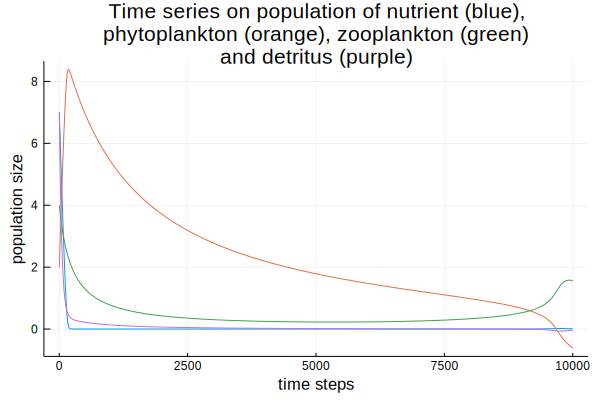

In [14]:
## model testing
t = sc.linspace(0, 30, 10000) # time series (days)

## parameters
pops = sc.array([7,2,4,7]) # population size/density: NPZD
kSer = sc.array([.85,.5,.6,.5]) # half-saturation constant: NPZD
mSer = sc.array([.015,.025,.02,.34,.06,6.43]) # mortality: P1 P2 Z1 Z2 D sink_D
zSer = sc.array([1,.69,.75]) # zooplankton details: ingestion rate, absorption rate, net production efficiency
arb = sc.array([.0174,3.91]) # subthermocline linear data plot
depth = sc.array([1,0,.13]) # water depth details: water col height, rate of thermocline shift, cross-thermocline mixing (detritivore dominant once without layer mixing in water column)
Temp = 30 # water surface temperature
GR0deg = 3 # phytoplankton growth rate at 0 deg Celcius
IntMax = 9 # max light intensity
irradiance = 200 # irradiance at water surface

pops, infodict = itg.odeint(empower, pops, t, full_output=true, args=(kSer, mSer, zSer, arb, depth, Temp, GR0deg, IntMax, irradiance))
plot(pops, xlabel="time steps", ylabel="population size", title="Time series on population of nutrient (blue),\nphytoplankton (orange), zooplankton (green)\nand detritus (purple)", label="")

# carbon sequestration revenue (photosynthesis) rate
\begin{equation}
    V_P|_{T^{o}C} = V_P^{max}|_{0^{o}C}\Big[1-exp\Big(\dfrac{-\alpha\cdot i(t,z)}{V_P^{max}|_{0^{o}C}}\Big)\Big]
\end{equation}

Carbon sequestration should be related to photosynthesis, as the process can fix 6 atmospheric carbon dioxide molecules into one glucose or two pyruvate molecules.  The general chemical equations are:
\begin{equation}
    6\text{CO}_2 + \text{NADPH}_2^+ \rightarrow_\text{photosynthesis}^\text{chlorophyll & thylakoid}\rightarrow \text{glucose} + \text{NADP}^+
\end{equation}
\begin{equation}
    6\text{CO}_2 + \text{NADPH}_2^+ \rightarrow_\text{photosynthesis}^\text{chlorophyll & thylakoid}\rightarrow 2\text{pyruvate} + \text{NADP}^+
\end{equation}

In the temperature-dependent photosynthesis rate equation ($V_P|_{T^{o}C}$):
* $V_P^{max}|_{0^{o}C}$ is the standardized maximum photosynthesis rate under 0$^oC$
* the above term has been modified by a flipped decreasing exponential term (with asymptote +1)
* the exponent ($\dfrac{-\alpha\cdot i(t,z)}{V_P^{max}|_{0^{o}C}}$) is a negative fraction based on the standardized max photosynthesis rate modified by initial slope of P-I (photosynthesis-light intensity) curve ($\alpha$) and light intensity ($i(t,z)$) at the specific depth-time position ($z$, $t$)

In [15]:
function CseqRevRate(P, VpMx0, a, iT, r, z) ## tested
    ## VpMx0 = max rate photosynthesis 0 degC
    ## a = initial slope of P-I curve
    ## r = cyanobacteria cell radius (mm)
    
    Vp = VpMx0*(1-mt.exp(-a*intensity(P, iT, r, z)/VpMx0))
    return(Vp)
end

CseqRevRate (generic function with 1 method)

# electricigen detritivore population-electricity relationship
[paper](https://www.researchgate.net/publication/264452305_ELECTRICITY_GENERATION_IN_MICROBIAL_FUEL_CELL_BY_THE_DECOMPOSITION_OF_ORGANIC_SLURRY_USING_E-COLI) with typical population density [here](https://www.mdpi.com/1660-4601/9/3/746), power output estimated by simple ratio

# eco-bioelectric cell (EBC)

eco-bioelectric cell ODEs
\begin{equation}
    \left\{\begin{array}{rl}
        N'(t) &= -\mu_PP + \varepsilon_{BD}(1-b_B)B\\
        P'(t) &= \mu_PP - m_{P1}P - m_{P2}P^2\\
        B'(t) &= \varepsilon_{BD}b_Bk_{NB} - m_{B1}B - m_{B2}B^2\\
        D'(t) &= m_{P1}P + m_{P2}P^2 + m_{B1}B + m_{B2}B^2 - \varepsilon_{BD}D
    \end{array}\right.
\end{equation}
parameters
term | unit | meaning  
--- | --- | ---  
$N$ | X | pool size of N  
$P$ | X | population size of P  
$B$ | X | population size of B  
$D$ | X | pool size of D  
$\mu_P$ | . | growth rate of P  
$\varepsilon_{BD}$ | dimensionless | encounter rate of B&D (and B eat D)  
$b_B$ | dimensionless | absorption efficiency of B  
$m_{P1}$ | . | linear death rate of P  
$m_{P2}$ | . | quadratic death rate of P  
$m_{B1}$ | . | linear death rate of B  
$m_{B2}$ | . | quadratic death rate of B  
$k_{NB}$ | . | energy-biomass conversion efficiency of B (assume D->N->B)  

Given general logistic growth equation
\begin{align*}
    \dfrac{d[pop]}{dt} &= r(k-[pop])[pop]\\
    &= rk[pop] - r[pop]^2
\end{align*}
\begin{equation}
\begin{array}{rl}
    rk &= \mu_P - m_{P1}\\
    k &= \dfrac{\mu_P - m_{P1}}{m_{P2}}\\
    m_{P1} &= \mu_P - rk
\end{array}\qquad\qquad\begin{array}{rl}
    r &= m_{P2}
\end{array}
\end{equation}

With the base overarching equations as base and biological interactions between parties in mind, I proposed the follow modified NPZD model meeting the situation for the eco-bioelectric cell.

1. the cell is assumed to be a thin layer structured, hence thermocline terms are not useful and removed
2. zooplankton in this model is indeed the detritivore _E. coli_, which is a bacteria (hence $Z\rightarrow B$) and only ingest detritus (organic matter) as sole food source
3. the NPZD model don't have the quadratic death term of zooplankton without clear reason, so there should be no reason to eliminate that quadratic death term for _E. coli_ ($m_{B2}B^2$) in this general model
4. currently the chlorophyll concentration is detached from phytoplankton population size, which links would be established in the final model

ODE for nutrient [N'(t)]:
* $\mu_P$ (same with the NPZD model)
* $\varepsilon_{BD}(1-b_B)$ similar with the NPZD model, digested ($\varepsilon_{BD}$) but not absorbed ($1-b_B$) by detritivores, population dependent of the detritivores

ODE for phytoplankton [P'(t)]:
* $\mu_P$ (same with the NPZD model)
* $m_{P1}$ (same with the NPZD model)
* $m_{P2}$ (same with the NPZD model)

ODE for detritivore/bacteria [B'(t)]:
* $\varepsilon_{BD}b_Bk_{NB}$ encountered/digested ($\varepsilon_{BD}$), absorbed ($b_B$) and energy-wise used ($k_{NB}$) by detritivores, population dependent of the detritivores (assuming encounter = capture and digested)
* $m_{B1}$ (same function with the NPZD model zooplankton correspondent term description)
* $m_{B2}$ (same function with the NPZD model zooplankton correspondent term description)

ODE for detritus/organic matter [D'(t)]:
* $m_{P1}$ (same with the NPZD model)
* $m_{P2}$ (same with the NPZD model)
* $m_{B1}$ (same function with the NPZD model zooplankton correspondent term description)
* $m_{B2}$ (same function with the NPZD model zooplankton correspondent term description)
* $\varepsilon_{BD}$ encountered/digested according to the population pool of detritus

In [16]:
## zooplankton [Z] -> detritivore [B] (special zooplankton which only ingest detritus)
#function ebc(pops, t, kSer, mSer, zSer, Temp, GR0deg, IntMax, irradiance, radius, Ht)
function ebc(pops, t, kSer, mSer, zSer, Temp, GR0deg, IntMax, irradiance, Ht)
    ig = zSer[:1] # ingestion/encounter rate
    bB = zSer[:2] # absorption rate
    kNB = zSer[:3] # net production efficiency
    
#    muP = gRateP(pops, kSer, GR0deg, Temp, IntMax, irradiance, radius, Ht)
    muP = gRP(pops, kSer, GR0deg, Temp, IntMax, irradiance, Ht)
    
    N = pops[:1] # nutrient population size
    P = pops[:2] # phytoplankton population size
    B = pops[:3] # detritivore population size
    D = pops[:4] # detritius population size
        
    mP1 = mSer[:1] # phytoplankton mortality (lin)
    mP2 = mSer[:2] # phytoplankton mortality (qua)
    mB1 = mSer[:3] # detritivore mortality (lin)
    mB2 = mSer[:4] # detritivore mortality (qua)
    
    # N: nutrient to phyto [-], digested but not absorbed from detritivores [+]
    dN = -muP*P +ig*(1-bB)*B
    
    if P > 0
        # P: nutrient absorbed [+], death [-], more death [-]
        dP = muP*P -mP1*P -mP2*P^2
    else
        dP = 0 # if eliminated, can't recover
    end
    
    if B > 0
        # B: digested, absorbed & used [+], death [-], more death [-]
        dB = ig*bB*kNB -mB1*B -mB2*B^2
    else
        dB = 0 # if eliminated, can't recover
    end
        
    # D: phyto death [+], phyto more death [+], detritivore death [+], detritivore more death [+], D get destroyed once encountered with detritivore [-]
    dD = mP1*P +mP2*P^2 +mB1*B +mB2*B^2 -ig*D
    
    return(sc.array([dN,dP,dB,dD]))
end

ebc (generic function with 1 method)

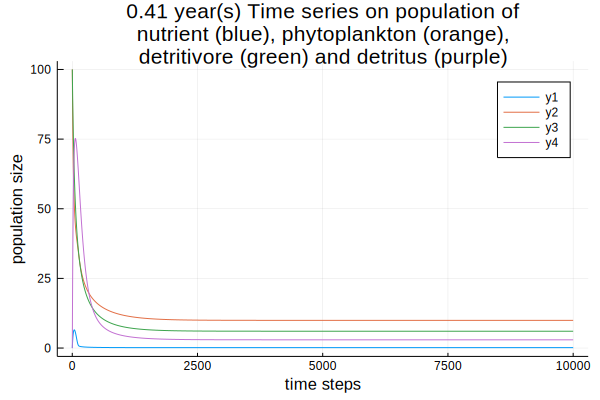

In [20]:
## model testing
x=150
t = sc.linspace(0, x, 10000) # time series (days)

## parameters
pops = sc.array([0,100,100,0]) # population size/density: NPBD
kSer = sc.array([.85,0,0,0]) # half-saturation constant: NPBD
mSer = sc.array([.02,.02,.02,.01]) # mortality: P1 [overall P growth rate] B1 [overall B growth rate]
zSer = sc.array([.9,.6,.9]) # zooplankton details: ingestion rate, absorption rate (high value = over-exploitation), net production efficiency
Temp = 18 # water surface temperature
GR0deg = 3 # phytoplankton growth rate at 0 deg Celcius
IntMax = 1490 # max light intensity
irradiance = 200 # irradiance at water surface
Ht = 1 # water column depth

pops, infodict = itg.odeint(ebc, pops, t, full_output=true, args=(kSer, mSer, zSer, Temp, GR0deg, IntMax, irradiance, Ht))

plot(pops, xlabel="time steps", ylabel="population size", title=string(round(x/365,digits=2))*" year(s) Time series on population of\nnutrient (blue), phytoplankton (orange),\ndetritivore (green) and detritus (purple)")

In [18]:
pops

10000×4 Array{Float64,2}:
 0.0        100.0      100.0       0.0    
 0.452503    97.1401    98.4999    4.42063
 0.80166     94.5353    97.0439    8.57951
 1.08927     92.1272    95.6301   12.4988 
 1.33102     89.8865    94.2567   16.1972 
 1.53516     87.7937    92.922    19.6908 
 1.7069      85.8334    91.6244   22.9942 
 1.84994     83.9934    90.3623   26.1201 
 1.96714     82.263     89.1344   29.0804 
 2.06083     80.633     87.9393   31.8856 
 2.13304     79.0952    86.7756   34.5453 
 2.18554     77.6424    85.6421   37.0683 
 2.21997     76.2678    84.5378   39.4628 
 ⋮                                        
 0.0607793    9.94122    6.04273   2.95709
 0.0607793    9.94122    6.04273   2.95709
 0.0607793    9.94122    6.04273   2.95709
 0.0607793    9.94122    6.04273   2.95709
 0.0607793    9.94122    6.04273   2.95709
 0.0607793    9.94122    6.04273   2.95709
 0.0607793    9.94122    6.04273   2.95709
 0.0607793    9.94122    6.04273   2.95709
 0.0607793    9.94122    6.0

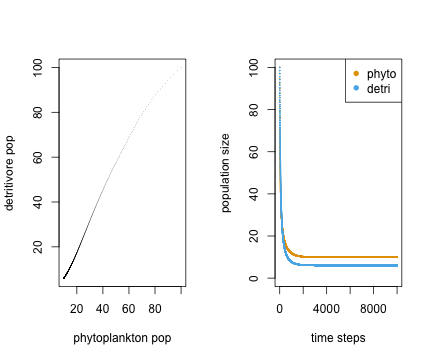

RObject{VecSxp}
$rect
$rect$w
[1] 4802.543

$rect$h
[1] 20.50633

$rect$left
[1] 5597.417

$rect$top
[1] 104


$text
$text$x
[1] 7438.142 7438.142

$text$y
[1] 97.16456 90.32911




In [19]:
@rput pops
R"
s<-1:nrow(pops)
par(mfrow=c(1,2))
plot(pops[,2],pops[,3], xlab='phytoplankton pop', ylab='detritivore pop', pch=16, cex=.1)
plot(s,pops[,2], col=cbp[2], cex=.1, ylim=c(0,max(pops[,2:3])), xlab='time steps', ylab='population size')
points(s,pops[,3], col=cbp[3], cex=.1)
legend('topright',legend=c('phyto','detri'),pch=16,col=cbp[2:3])
"